# Wide ResNet Experiments

In [1]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_VISIBLE_DEVICES=1


In [59]:
import sys

import numpy as np
import os
import blosc

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import os
import blosc
import simplejson
import json
import pickle

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.contrib.layers import xavier_initializer_conv2d
from scipy.interpolate import spline
from collections import defaultdict

sys.path.append("..")
    
from dataset import DatasetIndex, Dataset
from dataset import Batch, action, model, inbatch_parallel
from wide import MnistBatch
from wide import draw_stats

In [3]:
def parameters_count(ppl):
    all_layers = ppl.get_model_by_name('resnet')[-1][-1].graph.get_collection('trainable_variables')
    n_parameters = 0
    for layer in all_layers:
        current_n = 1
        for dim_shape in (layer.get_shape().as_list()):
            current_n *= dim_shape
        n_parameters += current_n
    return (n_parameters)

### Загрузим данные MNIST:

In [4]:
src = 'C:/Users/Dari/Documents/az_training/task_03'

with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

# LEN_MNIST = 65000
# indy = DatasetIndex(np.arange(LEN_MNIST))

# mnistset = Dataset(indy, batch_class=MnistBatch)
# mnistset.cv_split([0.9, 0.1])

ix = DatasetIndex(range(58500))
train_dataset = Dataset(ix, MnistBatch)


In [5]:
test_ix = DatasetIndex(range(65000-58500))
test_dataset = Dataset(test_ix, MnistBatch)

### TRAIN

In [15]:
widening_factors = [2, 1]
length_factors = [1, 1]
add_blocks = [2, 8]

test_losses_lengths = defaultdict(list)
test_accs_lengths = defaultdict(list)
train_times_lengths = defaultdict(list)
pipelines_dict_length  = defaultdict(list)

n_iterations = 400

In [16]:
for index, wid_factor in enumerate(widening_factors):
    config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                    'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                    'factor':wid_factor, \
                    'length_factor':length_factors[index], \
                    'add_blocks':add_blocks[index]}}
    stats = []
    loss_history = []
    time_list = []

    ppl = (train_dataset.pipeline(config=config).
       train_res(loss_history, stats, src[0][:58500], full_labs[:58500], time_list))

    current_loss = []
    current_acc = []
    test_ppl = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss, current_acc, src[0][58500:], full_labs[58500:]))

    print('current config', config['resnet']['factor'])


    for i in tqdm(range(n_iterations)):
        ppl.next_batch(100, n_epochs=None, shuffle=2)
        test_ppl.next_batch(100, n_epochs=None, shuffle=2)

    print ('time ', np.mean(np.array(time_list)))

    test_losses_lengths[str(11) + '+' + str(index+1)] = current_loss
    test_accs_lengths[str(11) + '+' + str(index+1)] = current_acc
    train_times_lengths[str(11) + '+' + str(index+1)] = time_list

    pipelines_dict_length[str(11) + '+' + str(index+1)]  = ppl

current config 2


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

32 32
64 64
128 128
128 128
128 128


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [06:12<00:00,  1.06it/s]


time  0.404832267275
current config 1


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

16 16
32 32
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [06:25<00:00,  1.10it/s]


time  0.427955462605


In [9]:
widening_factors = [3 ,2, 1]
length_factors = [1, 2, 8]
add_blocks = [0, 0, 0]

In [10]:
for index, wid_factor in enumerate(widening_factors):
    config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                    'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                    'factor':wid_factor, \
                    'length_factor':length_factors[index], \
                    'add_blocks':add_blocks[index]}}
    stats = []
    loss_history = []
    time_list = []

    ppl = (train_dataset.pipeline(config=config).
       train_res(loss_history, stats, src[0][:58500], full_labs[:58500], time_list))

    current_loss = []
    current_acc = []
    test_ppl = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss, current_acc, src[0][58500:], full_labs[58500:]))

    print('current config', config['resnet']['factor'])


    for i in tqdm(range(n_iterations)):
        ppl.next_batch(100, n_epochs=None, shuffle=2)
        test_ppl.next_batch(100, n_epochs=None, shuffle=2)

    print ('time ', np.mean(np.array(time_list)))

    test_losses_lengths[str(index) + '+' + str(index)] = current_loss
    test_accs_lengths[str(index) + '+' + str(index)] = current_acc
    train_times_lengths[str(index) + '+' + str(index)] = time_list

    pipelines_dict_length[str(index) + '+' + str(index)]  = ppl

current config 3


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

48 48
96 96
192 192


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [04:12<00:00,  1.59it/s]


time  0.276595314329
current config 2


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

32 32
32 32
64 64
64 64
128 128
128 128


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [04:49<00:00,  1.40it/s]


time  0.316600982244
current config 1


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [07:25<00:00,  1.28s/it]


time  0.507331908985


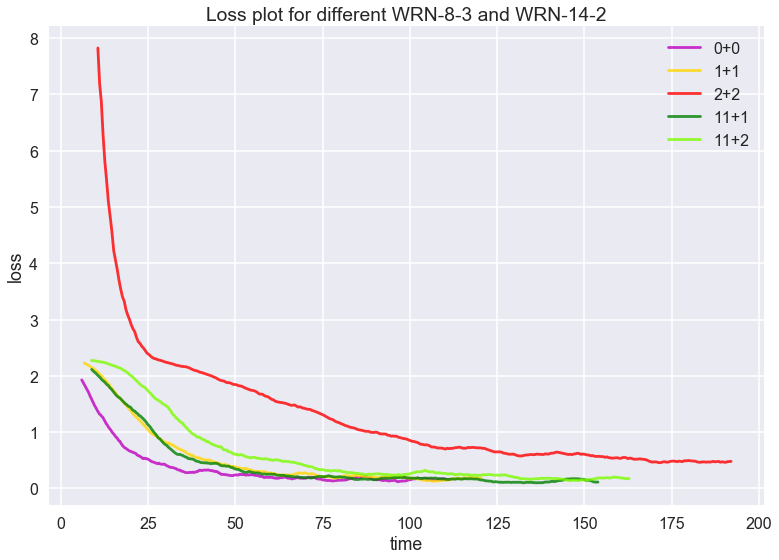

In [56]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different WRN-8-3 and WRN-14-2')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' , 'c', 'midnightblue']
keys_300 = ['0+0', '1+1', '2+2', '11+1', '11+2']
factors = ['wide resnet d=3, l=1', 'thin resnet d=2, l=2', 'thin d=1, l=8', '', '', '']
for index, current in enumerate(keys_300):
    current_time = np.cumsum(train_times_lengths[current])
    current_loss = test_losses_lengths[current]
#     if index < 6 and index >0:
#         continue
    smoothed_current = []
    for i in range(10, len(current_loss) - 10):
        smoothed_current.append(np.mean(current_loss[i-10:i+10]))

#     plt.plot(current_time[:], current_loss[:], c=cols[index], label = keys_300[index], alpha=0.8)
    plt.plot(current_time[20:len(smoothed_current)], smoothed_current[20:], c=cols[index], label = keys_300[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('loss')
plt.show()

In [54]:
for ppl_i in pipelines_dict_length.keys():
    print(ppl_i, ' ', parameters_count(pipelines_dict_length[ppl_i]))

11+0   677274
11+1   927178
11+2   702458
0+0   677274
1+1   691338
2+2   757274


AttributeError: 'list' object has no attribute 'get_model_by_name'

In [20]:
pipelines_dict_length['0+0'].config

{'resnet': {'add_blocks': 0,
  'conv_initializer': <function tensorflow.contrib.layers.python.layers.initializers.variance_scaling_initializer.<locals>._initializer>,
  'dense_initializer': <function tensorflow.contrib.layers.python.layers.initializers.variance_scaling_initializer.<locals>._initializer>,
  'factor': 3,
  'length_factor': 1}}

In [97]:
np.mean(np.array(test_accs_lengths['0+0'][390:]))

0.954

In [25]:
ppl.config

{'resnet': {'add_blocks': 0,
  'conv_initializer': <function tensorflow.contrib.layers.python.layers.initializers.variance_scaling_initializer.<locals>._initializer>,
  'dense_initializer': <function tensorflow.contrib.layers.python.layers.initializers.variance_scaling_initializer.<locals>._initializer>,
  'factor': 3,
  'length_factor': 1}}

In [91]:
with open("loss_results.txt", "wb") as a:
    pickle.dump(test_losses_lengths, a)

In [92]:
with open("accs_results.txt", "wb") as a:
    pickle.dump(test_accs_lengths, a)

In [95]:
with open("time_results.txt", "wb") as a:
    pickle.dump(train_times_lengths, a)

In [73]:
for i in test_losses_lengths.keys():
    print(len(test_losses_lengths[i]))

400
400
400
400
400
400
400
400


In [76]:
a.close()

In [78]:
чhs)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'collections.defaultdict'

In [ ]:
test_losses_lengths

In [86]:
# f_stats = open('init_stats.txt', 'w')
# f_loss = open('init_loss.txt', 'w')

widening_factors = [1]
length_factors = [8]

for index, wid_factor in enumerate(widening_factors):
    config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                    'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                    'factor':wid_factor, \
                    'length_factor':length_factors[index]}}
    stats = []
    loss_history = []
    time_list = []

    ppl = (train_dataset.pipeline(config=config).
       train_res(loss_history, stats, src[0][:58500], full_labs[:58500], time_list))

    current_loss = []
    current_acc = []
    test_ppl = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss, current_acc, src[0][58500:], full_labs[58500:]))

    print('current config', config['resnet']['factor'])


    for i in tqdm(range(n_iterations)):
        ppl.next_batch(100, n_epochs=None, shuffle=2)
        test_ppl.next_batch(100, n_epochs=None, shuffle=2)

    print ('time ', np.mean(np.array(time_list)))

    test_losses_lengths[str(index) + '+' + str(8)] = current_loss
    test_accs_lengths[str(index) + '+' + str(8)] = current_acc
    train_times_lengths[str(index) + '+' + str(8)] = time_list

    pipelines_dict_length[str(index) + '+' + str(8)]  = ppl

#         f_stats.write('\t'.join(map(str, stats)))
#         f_stats.write('\n')

#         f_loss.write('\t'.join(map(str, loss_history)))
#         f_loss.write('\n')

current config 1


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [07:52<00:00,  1.16s/it]


time  0.538135023467


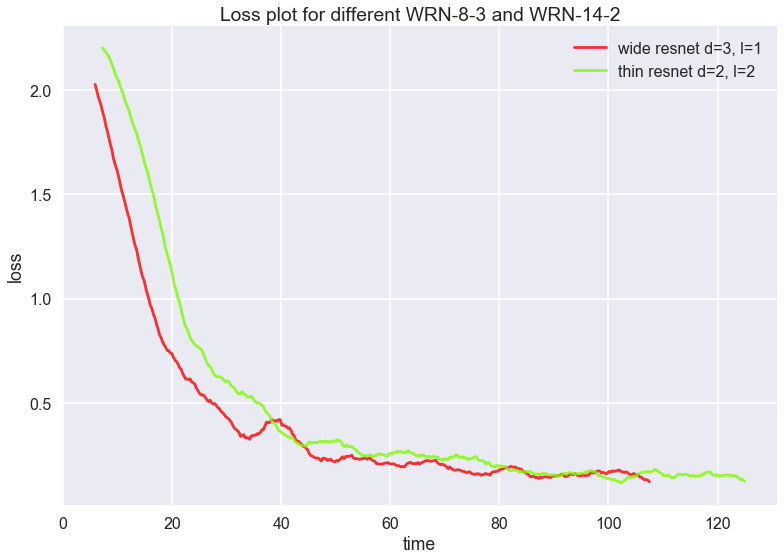

In [95]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different WRN-8-3 and WRN-14-2')
cols = ['r', 'lawngreen', 'blue']
keys_300 = ['0+0', '1+1']
factors = ['wide resnet d=3, l=1', 'thin resnet d=2, l=2', 'thin d=1, l=8']
for index, current in enumerate(keys_300):
    current_time = np.cumsum(train_times_lengths[current])
    current_loss = test_losses_lengths[current]
    
    smoothed_current = []
    for i in range(10, len(current_loss) - 10):
        smoothed_current.append(np.mean(current_loss[i-10:i+10]))
#     if index == 1:
#         plt.plot(current_time[:229], current_loss[:229], c=cols[index], label = factors[index], alpha=0.8)
#     else:
    plt.plot(current_time[20:len(smoothed_current)], smoothed_current[20:], c=cols[index], label = factors[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('loss')
plt.show()

In [88]:
parameters_count(ppl)

757274

In [15]:
widening_factors = [1]
length_factors = [2, 4, 15, 20]


In [14]:
test_losses_lengths = defaultdict(list)
test_accs_lengths = defaultdict(list)
train_times_lengths = defaultdict(list)

In [16]:
f_stats = open('init_stats.txt', 'w')
f_loss = open('init_loss.txt', 'w')

for index, wid_factor in enumerate(widening_factors):
    for l_index, l_factor in enumerate(length_factors):
        config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                        'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                        'factor':wid_factor, \
                        'length_factor':length_factors[l_index]}}
        stats = []
        loss_history = []
        time_list = []
        
        ppl = (train_dataset.pipeline(config=config).
           train_res(loss_history, stats, src[0][:58500], full_labs[:58500], time_list))

        current_loss = []
        current_acc = []
        test_ppl = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss, current_acc, src[0][58500:], full_labs[58500:]))
        
        print('current config', config['resnet']['factor'])
        
        
        for i in tqdm(range(n_iterations)):
            ppl.next_batch(100, n_epochs=None, shuffle=2)
            test_ppl.next_batch(100, n_epochs=None, shuffle=2)
        
        print ('time ', np.mean(np.array(time_list)))

        test_losses[str(index) + '+' + str(l_index)] = current_loss
        test_accs[str(index) + '+' + str(l_index)] = current_acc
        train_times[str(index) + '+' + str(l_index)] = time_list
        
        pipelines_dict[str(index) + '+' + str(l_index)]  = ppl

        f_stats.write('\t'.join(map(str, stats)))
        f_stats.write('\n')

        f_loss.write('\t'.join(map(str, loss_history)))
        f_loss.write('\n')

current config 1


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

16 16
16 16
32 32
32 32
64 64
64 64


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:01<00:00,  3.48it/s]


time  0.135669528734
current config 1


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

16 16
16 16
16 16
16 16
32 32
32 32
32 32
32 32
64 64
64 64
64 64
64 64


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [03:46<00:00,  1.79it/s]


time  0.26007857953
current config 1


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [14:05<00:00,  2.08s/it]


time  0.971512890245
current config 1


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
16 16
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [19:22<00:00,  2.87s/it]


time  1.32738997298


In [25]:
for ppl_i in pipelines_dict.keys():
    print('here ', parameters_count(pipelines_dict[ppl_i]), ' ', ppl_i)

here  175322   0+0
here  303818   1+0
here  1198698   2+0
here  2685450   3+0
here  369306   0+1
here  1436218   0+2
here  1921178   0+3


In [19]:
pipelines_dict

defaultdict(None,
            {'0+0': <dataset.dataset.pipeline.Pipeline at 0x1b98f248160>,
             '0+1': <dataset.dataset.pipeline.Pipeline at 0x1b988c4d7b8>,
             '0+2': <dataset.dataset.pipeline.Pipeline at 0x1b99354aeb8>,
             '0+3': <dataset.dataset.pipeline.Pipeline at 0x1b9a617a828>,
             '1+0': <dataset.dataset.pipeline.Pipeline at 0x1b98a1626a0>,
             '2+0': <dataset.dataset.pipeline.Pipeline at 0x1b98c0e9908>,
             '3+0': <dataset.dataset.pipeline.Pipeline at 0x1b98da61710>})

In [40]:
np.where(np.abs(current_time - 60) < 0.3 )

(array([229, 230], dtype=int64),)

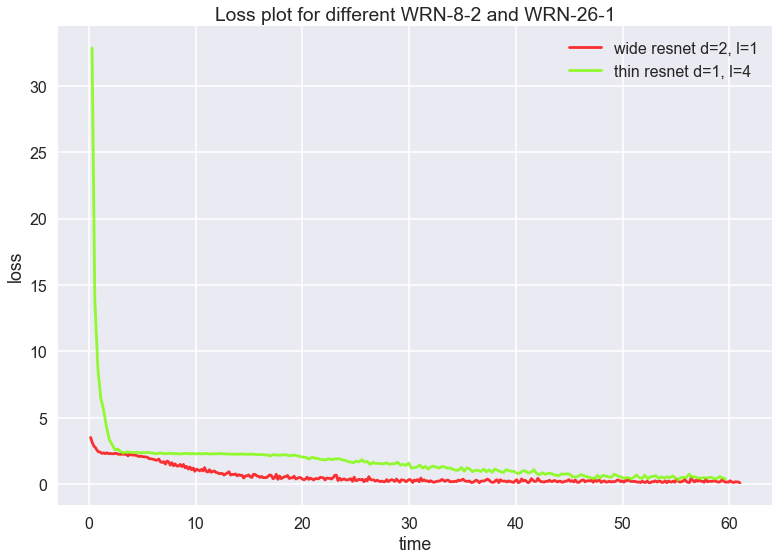

In [46]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different WRN-8-2 and WRN-26-1')
cols = ['r', 'lawngreen']
keys_300 = ['1+0', '0+1']
factors = ['wide resnet d=2, l=1', 'thin resnet d=1, l=4']
for index, current in enumerate(keys_300):
    current_time = np.cumsum(train_times[current])
    current_loss = test_losses[current]

    smoothed_current = []
    for i in range(10, len(current_loss) - 10):
        smoothed_current.append(np.mean(current_loss[i-10:i+10]))
    if index == 1:
        plt.plot(current_time[:229], current_loss[:229], c=cols[index], label = factors[index], alpha=0.8)
    else:
        plt.plot(current_time, current_loss, c=cols[index], label = factors[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('loss')
plt.show()

##### np.where(np.abs(current_time - 25) < 1 )

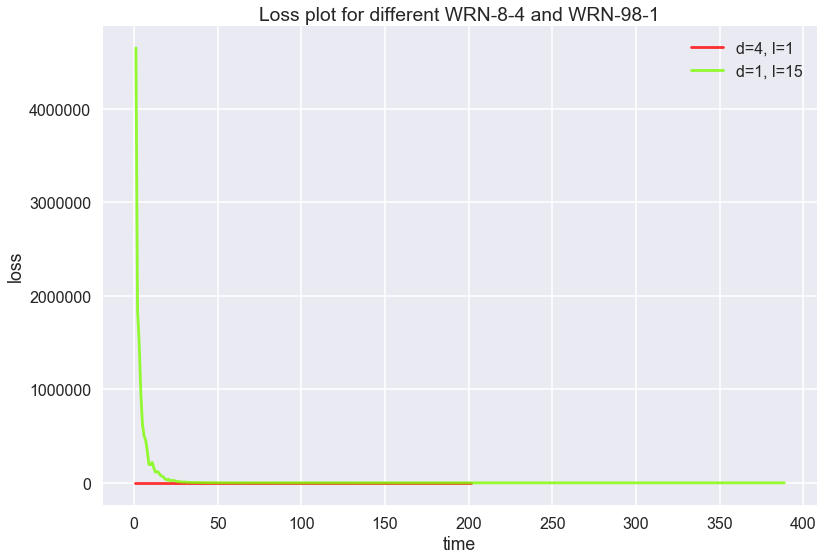

In [69]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different WRN-8-4 and WRN-98-1')
cols = ['r', 'lawngreen']
keys_300 = ['2+0', '0+2']
factors = ['d=4, l=1', 'd=1, l=15']
for index, current in enumerate(keys_300):
    current_time = np.cumsum(train_times[current])
#     if index == 0:
#         continue
    current_loss = test_losses[current]
    smoothed_current = []
    for i in range(10, len(current_loss) - 10):
        smoothed_current.append(np.mean(current_loss[i-10:i+10]))
    if index == 1:
        plt.plot(current_time[:], current_loss[:], c=cols[index], label = factors[index], alpha=0.8)
    else:
        plt.plot(current_time[0:], current_loss[0:], c=cols[index], label = factors[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('loss')
plt.show()

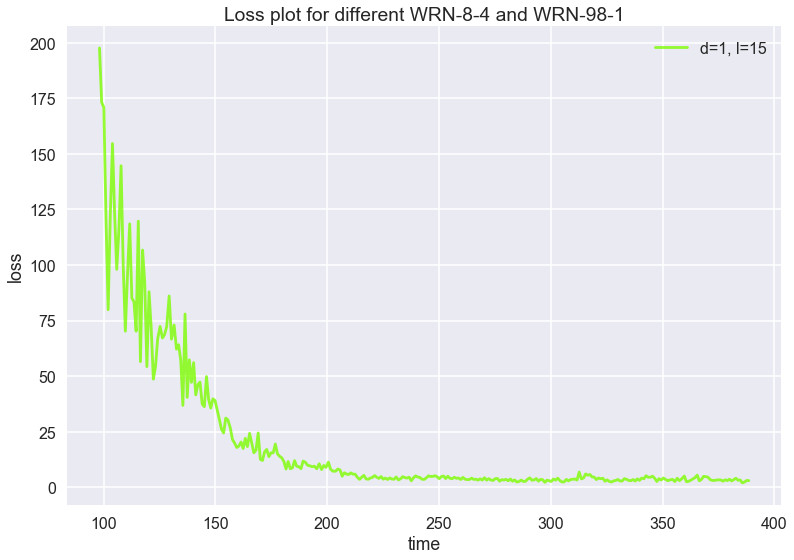

In [72]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different WRN-8-4 and WRN-98-1')
cols = ['r', 'lawngreen']
keys_300 = ['2+0', '0+2']
factors = ['d=4, l=1', 'd=1, l=15']
for index, current in enumerate(keys_300):
    current_time = np.cumsum(train_times[current])
    if index == 0:
        continue
    current_loss = test_losses[current]
    smoothed_current = []
    for i in range(10, len(current_loss) - 10):
        smoothed_current.append(np.mean(current_loss[i-10:i+10]))
    if index == 1:
        plt.plot(current_time[100:], current_loss[100:], c=cols[index], label = factors[index], alpha=0.8)
    else:
        plt.plot(current_time[0:], current_loss[0:], c=cols[index], label = factors[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('loss')
plt.show()

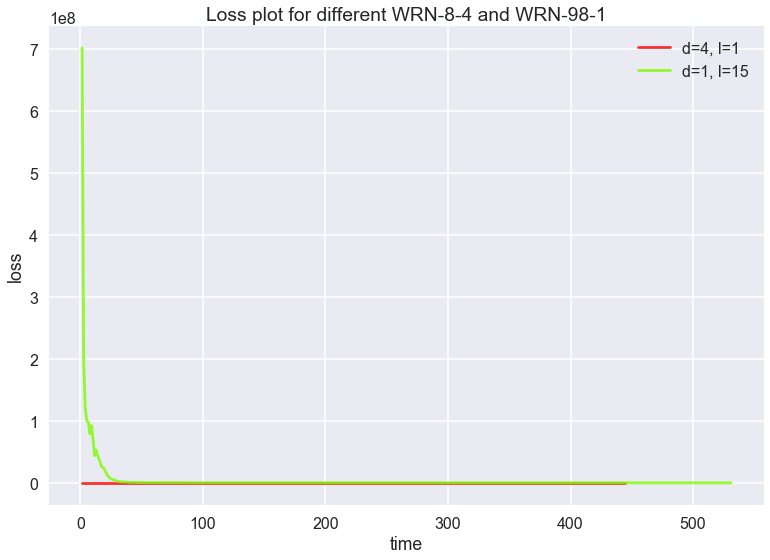

In [68]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different WRN-8-4 and WRN-98-1')
cols = ['r', 'lawngreen']
keys_300 = ['3+0', '0+3']
factors = ['d=4, l=1', 'd=1, l=15']
for index, current in enumerate(keys_300):
    current_time = np.cumsum(train_times[current])
#     if index == 0:
#         continue
    current_loss = test_losses[current]
    smoothed_current = []
    for i in range(10, len(current_loss) - 10):
        smoothed_current.append(np.mean(current_loss[i-10:i+10]))
    if index == 1:
        plt.plot(current_time[:], current_loss[:], c=cols[index], label = factors[index], alpha=0.8)
    else:
        plt.plot(current_time[0:], current_loss[0:], c=cols[index], label = factors[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('loss')
plt.show()

In [26]:
np.cumsum(train_times['1+0'])

array([  0.1669578 ,   0.3237179 ,   0.47638129,   0.62844478,
         0.77817219,   0.92774498,   1.08263359,   1.23468906,
         1.38767518,   1.53920698,   1.69134889,   1.8426236 ,
         1.99455253,   2.14503918,   2.29747501,   2.44984374,
         2.60134272,   2.75192966,   2.90353513,   3.05222796,
         3.20322662,   3.3532031 ,   3.52547672,   3.67485586,
         3.82695911,   3.9761406 ,   4.12679902,   4.28061294,
         4.43238798,   4.58295085,   4.73576667,   4.88741407,
         5.03936161,   5.19304862,   5.34644171,   5.49868062,
         5.6522648 ,   5.8048031 ,   5.9570121 ,   6.10906028,
         6.25779432,   6.41005036,   6.56335119,   6.71686608,
         6.86936427,   7.02415223,   7.17583975,   7.32650254,
         7.47862402,   7.62851042,   7.77988323,   7.93056681,
         8.08354199,   8.2388507 ,   8.40140216,   8.55475004,
         8.70880245,   8.86210766,   9.01606198,   9.16989924,
         9.32452857,   9.48139626,   9.63191136,   9.78

In [6]:
n_iterations = 400

In [7]:
widening_factors = list(range(1, 10))

In [8]:
widening_factors = [0.5, 1, 4]

In [9]:
widening_factors = [1, 2, 4, 6]
length_factors = [1]


In [10]:
convs_inits = [tf.contrib.layers.variance_scaling_initializer(factor=2.0)]
dense_inits = [tf.contrib.layers.variance_scaling_initializer(factor=2.0)]


In [11]:
test_losses = defaultdict(list)
test_accs = defaultdict(list)
train_times = defaultdict(list)

In [12]:
f_stats = open('init_stats.txt', 'w')
f_loss = open('init_loss.txt', 'w')
pipelines_dict = defaultdict()
times = []
for index, wid_factor in enumerate(widening_factors):
    for l_index, l_factor in enumerate(length_factors):
        config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                        'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                        'factor':wid_factor, \
                        'length_factor':length_factors[l_index]}}
        stats = []
        loss_history = []
        time_list = []
        
        ppl = (train_dataset.pipeline(config=config).
           train_res(loss_history, stats, src[0][:58500], full_labs[:58500], time_list))

        current_loss = []
        current_acc = []
        test_ppl = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss, current_acc, src[0][58500:], full_labs[58500:]))
        
        print('current config', config['resnet']['factor'])
        
        
        for i in tqdm(range(n_iterations)):
            ppl.next_batch(100, n_epochs=None, shuffle=2)
            test_ppl.next_batch(100, n_epochs=None, shuffle=2)
        
        print ('time ', np.mean(np.array(time_list)))

        test_losses[str(index) + '+' + str(l_index)] = current_loss
        test_accs[str(index) + '+' + str(l_index)] = current_acc
        train_times[str(index) + '+' + str(l_index)] = time_list
        
        pipelines_dict[str(index) + '+' + str(l_index)]  = ppl

        f_stats.write('\t'.join(map(str, stats)))
        f_stats.write('\n')

        f_loss.write('\t'.join(map(str, loss_history)))
        f_loss.write('\n')

current config 1


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

16 16
32 32
64 64


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:05<00:00,  6.76it/s]


time  0.0691238198301
current config 2


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

32 32
64 64
128 128


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:18<00:00,  2.91it/s]


time  0.152488111692
current config 4


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

64 64
128 128
256 256


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [07:12<00:00,  1.08s/it]


time  0.503910906976
current config 6


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

96 96
192 192
384 384


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [15:11<00:00,  2.27s/it]


time  1.11067786058


In [22]:
train_times['0+0']

[0.08041492383824789,
 0.07124779829260319,
 0.06739686163248848,
 0.06859043319391844,
 0.06853062698061763,
 0.066637614461456,
 0.06698660559627001,
 0.0703248133790737,
 0.06787895805908306,
 0.06709527786185276,
 0.06906195413156979,
 0.06821299764055766,
 0.06675759156001959,
 0.06793001214356309,
 0.06673607591011432,
 0.0687187977492556,
 0.06710512400672997,
 0.06596406521794052,
 0.06745119776527986,
 0.06931102512953657,
 0.06762222894838033,
 0.06667116428840814,
 0.06638197936686652,
 0.06591848121391308,
 0.0680868211174186,
 0.06576933035273669,
 0.06527337638894437,
 0.06767802376933219,
 0.06688705013147,
 0.06836579522206421,
 0.06780602365265054,
 0.06681192769281097,
 0.06730459960834878,
 0.06853864976534396,
 0.06574343863846366,
 0.0658346066464901,
 0.06786582986589451,
 0.06790083838100713,
 0.0666160988115223,
 0.0658914954835268,
 0.06855141328645686,
 0.06569931332256829,
 0.067265944372906,
 0.06785416036086644,
 0.06804123711341958,
 0.06790047370895991,
 

In [20]:
for ppl_i in pipelines_dict.values():
    parameters_count(ppl_i)

175322
303818
1198698
2685450
369306
1436218
1921178


In [11]:
f_loss.close()
f_stats.close()

with open('init_stats.txt', 'r') as f_1:
    stats = []
    for i in f_1.read().splitlines():
        stats.append(i.split('\t'))

with open('init_loss.txt', 'r') as f_2:
    loss_history = []
    for i in f_2.read().splitlines():
        loss_history.append(i.split('\t'))

In [33]:
253/365

0.6931506849315069

In [34]:
1-(365/337)**337.5/np.e**28

0.6544549176206023

In [42]:
test_accs.keys()

dict_keys([0, 1, 2, 3, 4, 5])

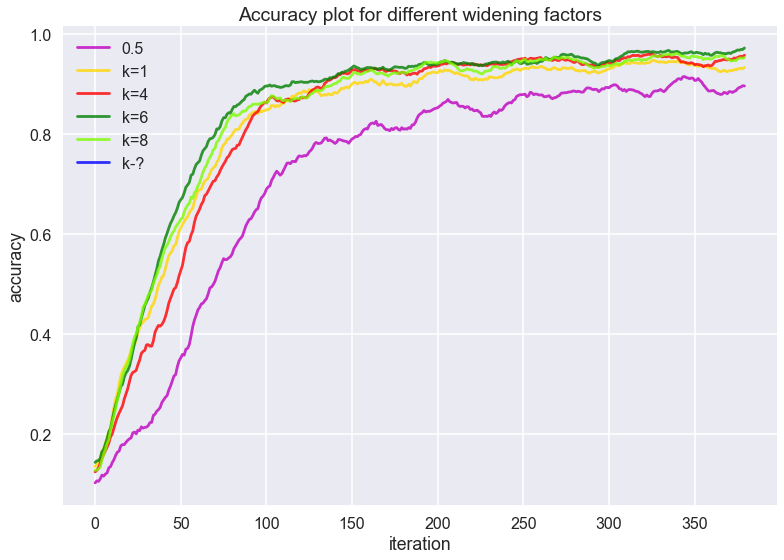

In [54]:
plt.style.use('seaborn-poster')
plt.title('Accuracy plot for different widening factors')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' ]
factors = ['0.5', 'k=1', \
              'k=4', 'k=6', 'k=8', 'k-?']

for index, current in enumerate(test_accs.values()):
#     plt.plot(current, c=cols[i], label = factors[i], alpha=0.5)
    smoothed_current = []
    for i in range(10, len(current) - 10):
        smoothed_current.append(np.mean(current[i-10:i+10]))
    plt.plot(smoothed_current, c=cols[index], label = factors[index], alpha=0.8)

plt.legend()
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

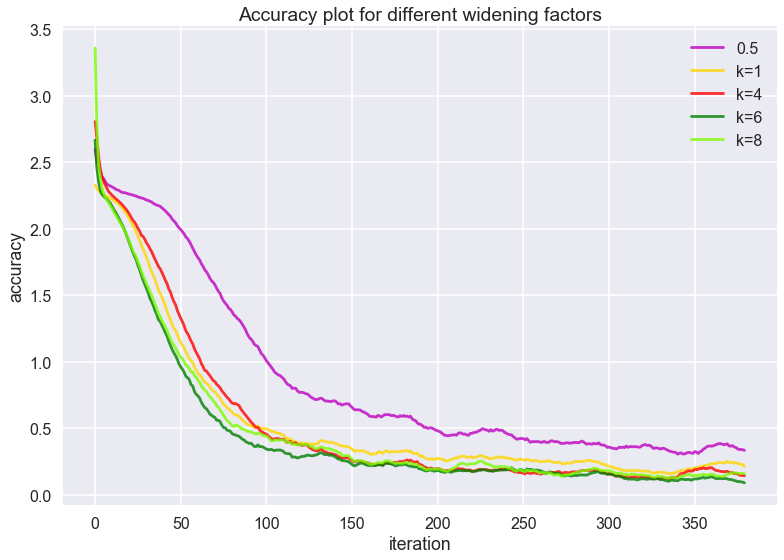

In [55]:
plt.style.use('seaborn-poster')
plt.title('Accuracy plot for different widening factors')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' ]
factors = ['0.5', 'k=1', \
              'k=4', 'k=6', 'k=8', 'k-?']

for index, current in enumerate(test_losses.values()):
#     plt.plot(current, c=cols[i], label = factors[i], alpha=0.5)
    smoothed_current = []
    for i in range(10, len(current) - 10):
        smoothed_current.append(np.mean(current[i-10:i+10]))
    plt.plot(smoothed_current, c=cols[index], label = factors[index], alpha=0.8)

plt.legend()
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

In [19]:
widening_factors = [6, 8]

In [20]:
f_stats = open('init_stats.txt', 'w')
f_loss = open('init_loss.txt', 'w')

for index, wid_factor in enumerate(widening_factors):
    config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                        'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                        'factor':wid_factor}}
    stats = []
    loss_history = []

    ppl = (train_dataset.pipeline(config=config).
       train_res(loss_history, stats, src[0][:58500], full_labs[:58500]))
    
    current_loss = []
    current_acc = []
    test_ppl = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss, current_acc, src[0][58500:], full_labs[58500:]))
        
#     ppl_test = test_dataset.pipeline(config=config)

    print('current config', config['resnet']['factor'])
    for i in tqdm(range(n_iterations)):
        ppl.next_batch(100, n_epochs=None, shuffle=2)
        test_ppl.next_batch(100, n_epochs=None, shuffle=2)

    test_losses[index+3] = current_loss
    test_accs[index+3] = current_acc
    
    pipelines.append(ppl)
    
    f_stats.write('\t'.join(map(str, stats)))
    f_stats.write('\n')
    
    f_loss.write('\t'.join(map(str, loss_history)))
    f_loss.write('\n')

current config 6


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

96 96
192 192
384 384


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [16:26<00:00,  2.39s/it]


current config 8


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

128 128
256 256
512 512


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [28:01<00:00,  4.12s/it]


In [ ]:
pi[]